In [1]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools

## Initialization

In [2]:
#--Data handling--
#Read of parameters for portfolio
def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['hydro'] = inputdata[['yi', 'P_min', 'P_max']].drop('Solar')
    data['solar']=inputdata[['yi', 'P_min', 'P_max']].drop('Hydro1').drop('Hydro2')
    return data

data = InputData('data/Parameters.xlsx')

#--Constants--
Constants= {
    'Load_penalty':200, 
    'Hydro_cap':80, 
    'Load':150,
    'Market':60,
}

# ----------------------Mathematical formulation ------------------------- #
# ----- First stage obejctive and constraints ------------------ #
def Obj_1st(model):
    return ((sum(model.yi[i] * model.p[i] for i in model.plants) - sum(model.Mi[i]*model.p[i] for i in model.plants))/len(scenarios)) + model.alpha #minimize(power produced - power sold to market)

def p_bounds(model,i):
    return (model.Pmin[i], model.Pmax[i])   

def Hydro_capacity(model, i):
    return model.p[i] <= model.H_stage1[i]

def CreateCuts(model,c):
    return(model.alpha >= model.Phi[c] - sum(model.Lambda[c,i]*(model.p[i]-model.x_hat[c,i]) for i in model.plants))  #only takes into account the hydro power production scheduling from H_cap

# ----- Second stage ojbective and constraints --------------#
def Obj_2nd(model):
    return (model.probs*(sum(model.yi[i]*model.p[i] for i in model.plants) + (model.Li * model.L_p)))


def Solar_rule(model):
    return model.phi == Solar_p

def Hydro_capacity2(model, i):      #ensures that model.p does not use more capacity than what it has available
    return model.p[i] <= model.H_stage2[i]

def load_rule(model):
    return model.p['Hydro1'] + model.p['Hydro2'] + model.phi == model.L - model.L_p 

def calculate_initial_H_stage2(Constants, X_hat):
    initial_H_stage2 = {}
    for plant in X_hat:
        remaining_capacity = Constants['Hydro_cap'] - (X_hat[plant])
        initial_H_stage2[plant] = remaining_capacity
    return initial_H_stage2
 
# ------------------------- MODEL SETUP -------------------------- #

# Set up model 1st stage
def ModelSetUp_1st(data, Constants,Cuts, Scenario):
    model = pyo.ConcreteModel()

    # Define sets and parameters specific to the first stage
    model.plants   =  pyo.Set(initialize=data['hydro'].index) 

    #Parameters
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage1 =  pyo.Param(model.plants, initialize=Constants['Hydro_cap'])                        #Initial capacity
    model.Mi       =  pyo.Param(model.plants, initialize=Constants['Market'])                           #Market sell price
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)

    # Variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)  

    # Constraints
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity)

    # Cuts information
    model.Cut      =  pyo.Set(initialize = Cuts["Set"])
    model.Phi      =  pyo.Param(model.Cut, initialize = Cuts["Phi"])
    model.Lambda   =  pyo.Param(model.Cut, model.plants, initialize = Cuts["lambda"])
    model.x_hat    =  pyo.Param(model.Cut, model.plants, initialize = Cuts["x_hat"])
    
    model.alpha    =  pyo.Var(bounds = (-100000000,100000000))
    
    model.CreateCuts   =  pyo.Constraint(model.Cut, rule = CreateCuts)

    # Define objective function
    model.obj      =  pyo.Objective(rule=Obj_1st, sense=pyo.minimize)
    
    return model

def ModelSetUp_2nd(data, Constants, X_hat, rem_cap, Scenario):
    # Instance
    model          =  pyo.ConcreteModel()

    # Define sets
    model.plants   =  pyo.Set(initialize=data['hydro'].index)  

    # Define parameters
    model.X_hat    =  pyo.Param(model.plants, initialize=X_hat)
    model.Li       =  pyo.Param(initialize=Constants['Load_penalty']) 
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage2 =  pyo.Param(model.plants, initialize=rem_cap)
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)


    # Define variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)
    model.phi      =  pyo.Var(within=pyo.NonNegativeReals)
    model.L_p      =  pyo.Var(within=pyo.NonNegativeReals)

    # Constraints
    model.load_cons    =  pyo.Constraint(rule=load_rule)
    model.solar_cons   =  pyo.Constraint(rule=Solar_rule)
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity2) #constraining power production from hydrom from the remaining capacity

    # Define objective function
    model.obj     =  pyo.Objective(rule=Obj_2nd, sense=pyo.minimize)
    
    return model


def Solve(model):
    opt = pyo.SolverFactory("gurobi")
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model, load_solutions=True)
    return results, model
def DisplayResults(model):
    return print(model.display(), model.dual.display())


# ----------------------- CUTTING ------------------------ #

# Function for creating new linear cuts for optimization problem
def Cut_manage(Cuts,model):
    """Add new cut to existing dictionary of cut information"""
    
    #Find cut iteration by checking number of existing cuts
    cut = len(Cuts["Set"])

    #Add new cut to list, since 0-index is a thing this works well
    Cuts["Set"].append(cut)
    
    #Find 2nd stage cost result
    Cuts["Phi"][cut] = pyo.value(model.obj)

    #Find lambda x_hat for each type of power produced
    for i in model.plants:
        Cuts["lambda"][cut, i] = model.dual.get(model.hydro_cons[i])  # the lambda should be the economic change when we increase the 1st decision by 1. Should be something else
        Cuts["x_hat"][cut,i] = model.X_hat[i]
    return(Cuts)

## Task 4b - SDP for one stochastic scenario ("High") for 10 discrete states

In [3]:
scenarios =  {'Avg':1}
solar_val_scenario = {'Avg':15}

tot_obj = 0

all_scenario_objective_values = []

for s in scenarios:
    print()
    print('---------------------------------------------------------------------')
    print("Solving for scenario:",s,"with probability:",np.round(scenarios[s]))
    print('---------------------------------------------------------------------')
    Solar_p = solar_val_scenario[s]          #input of solar data to be used in the optimization
    print("The amount of solar power for scenario",s,"is:",Solar_p,"MW")
    
    Min = 0
    Max = Constants["Hydro_cap"]

    states_jump = 8
    List_states = [i for i in range(Min,Max+states_jump,states_jump)]
    print("Number of discrete states:",len(List_states))

    Hydro1_initial_value = List_states
    Hydro2_initial_value = List_states
        
    List_combinations = [p for p in itertools.product(Hydro1_initial_value,Hydro2_initial_value)]

    #Pre-step: Formulate cut input data
    Cuts = {}
    Cuts["Set"] = []
    Cuts["Phi"] = {}
    Cuts["lambda"] = {}
    Cuts["x_hat"] = {}

    scenario_objective_values = []

    for initial_value in List_combinations:
        
        #Set 1st stage result
        X_hat = {
            "Hydro1": initial_value[0],
            "Hydro2": initial_value[1],
            }

        #Solve the 2nd stage problem for each state combination   
        initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat) 
        m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2, Scenario=scenarios[s])     
        Solve(m_2nd)

        #Aquire cuts
        Cuts = Cut_manage(Cuts,m_2nd)
        scenario_objective_values.append(pyo.value(m_2nd.obj))

    all_scenario_objective_values.append(scenario_objective_values)

    #Solve the 1st stage problem with the acquired cuts
    m_1st = ModelSetUp_1st(data, Constants,Cuts, Scenario=scenarios[s])
    Solve(m_1st)
        
    X_hat = {
            "Hydro1": m_1st.p["Hydro1"],
            "Hydro2": m_1st.p["Hydro2"],
        }

    #Print results 1st stage
    for x in X_hat:
        print("Remaining capacity in",x,"is:",X_hat[x].value,"MW")
        
    tot_obj += pyo.value(m_1st.obj())
    
print(">>>>-------------------------------------<<<<")
print("The total objective value is:",np.round(tot_obj))
print(">>>>-------------------------------------<<<<")


---------------------------------------------------------------------
Solving for scenario: Avg with probability: 1
---------------------------------------------------------------------
The amount of solar power for scenario Avg is: 15 MW
Number of discrete states: 11


Remaining capacity in Hydro1 is: 25.0 MW
Remaining capacity in Hydro2 is: 0.0 MW
>>>>-------------------------------------<<<<
The total objective value is: 3300.0
>>>>-------------------------------------<<<<


### Plotting of Task 4b:

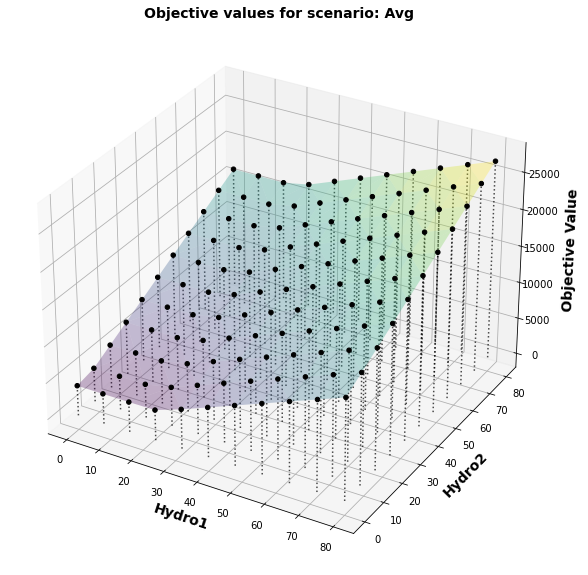

In [4]:
# Extract the first state and second state from each state combination tuple
state_combinations_x = [state[0] for state in List_combinations]
state_combinations_y = [state[1] for state in List_combinations]



# Plot state combinations and objective values for each scenario
for scenario_name, scenario_values in zip(scenarios.keys(), all_scenario_objective_values):
    slope = np.gradient(scenario_values)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    trisurf = ax.plot_trisurf(state_combinations_x, state_combinations_y, scenario_values, cmap=cm.viridis, linewidth=0.2, antialiased=True, alpha=0.3, facecolors=cm.viridis(slope))

    scatter = ax.scatter(state_combinations_x, state_combinations_y, scenario_values, color='black', marker='o', label='Objective value', alpha=1)
    #contour = ax.contour(state_combinations_x, state_combinations_y, scenario_values, zdir='z', offset=0, cmap='viridis', linestyles='dashed', alpha=0.5)
    
    # Draw dotted lines from scatter points
    for i in range(len(state_combinations_x)):
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [0, scenario_values[i]], linestyle='dotted', color='black', alpha=0.7)
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [scenario_values[i], scenario_values[i]], linestyle='dotted', color='C6', alpha=0.7)

    ax.set_xlabel("Hydro1",fontsize=14, fontweight='bold')
    ax.set_ylabel("Hydro2",fontsize=14, fontweight='bold')
    ax.set_zlabel("Objective Value",labelpad=10,fontsize=14, fontweight='bold')
    ax.set_title(f"Objective values for scenario: {scenario_name}",fontsize=14, fontweight='bold')

    plt.show()

## Task 4c - SDP for one stochastic scenario ("High") for 3 discrete states

In [5]:
scenarios          =  {'Avg':1}
solar_val_scenario =  {'Avg':15}

tot_obj = 0

all_scenario_objective_values = []

for s in scenarios:
    print()
    print('---------------------------------------------------------------------')
    print("Solving for scenario:",s,"with probability:",np.round(scenarios[s]))
    print('---------------------------------------------------------------------')
    Solar_p = solar_val_scenario[s]                    #input of solar data to be used in the optimization
    print("The amount of solar power for scenario",s,"is:",Solar_p,"MW")
    
    Min = 0
    Max = Constants["Hydro_cap"]

    states_jump = 40        #from 0 - 45 - 90 MW capacity in hydro_capacity
    List_states = [i for i in range(Min,Max+states_jump,states_jump)]
    print("Number of discrete states:",len(List_states))

    Hydro1_initial_value = List_states
    Hydro2_initial_value = List_states
        
    List_combinations = [p for p in itertools.product(Hydro1_initial_value,Hydro2_initial_value)]
   
    #Pre-step: Formulate cut input data
    Cuts = {}
    Cuts["Set"] = []
    Cuts["Phi"] = {}
    Cuts["lambda"] = {}
    Cuts["x_hat"] = {}

    scenario_objective_values = []

    for initial_value in List_combinations:
        
        #Set 1st stage result
        X_hat = {
            "Hydro1": initial_value[0],
            "Hydro2": initial_value[1],
            }

        #Solve the 2nd stage problem for each state combination   
        initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat) 
        m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2, Scenario=scenarios[s])     
        Solve(m_2nd)

        #Aquire cuts
        Cuts = Cut_manage(Cuts,m_2nd)
        scenario_objective_values.append(pyo.value(m_2nd.obj))

    all_scenario_objective_values.append(scenario_objective_values)

    #Solve the 1st stage problem with the acquired cuts
    m_1st = ModelSetUp_1st(data, Constants,Cuts, Scenario=scenarios[s])
    Solve(m_1st)
        
    X_hat = {
            "Hydro1": m_1st.p["Hydro1"],
            "Hydro2": m_1st.p["Hydro2"],
        }

    #Print results 1st stage
    for x in X_hat:
        print("Remaining capacity in",x,"is:",X_hat[x].value,"MW")

    tot_obj += pyo.value(m_1st.obj()) #.alpha.value

print(">>>>-------------------------------------<<<<")
print("The total objective value is:",np.round(tot_obj))
print(">>>>-------------------------------------<<<<")


---------------------------------------------------------------------
Solving for scenario: Avg with probability: 1
---------------------------------------------------------------------
The amount of solar power for scenario Avg is: 15 MW
Number of discrete states: 3


Remaining capacity in Hydro1 is: 24.714285714285715 MW
Remaining capacity in Hydro2 is: 0.0 MW
>>>>-------------------------------------<<<<
The total objective value is: 3260.0
>>>>-------------------------------------<<<<


### Plotting of Task 4c:

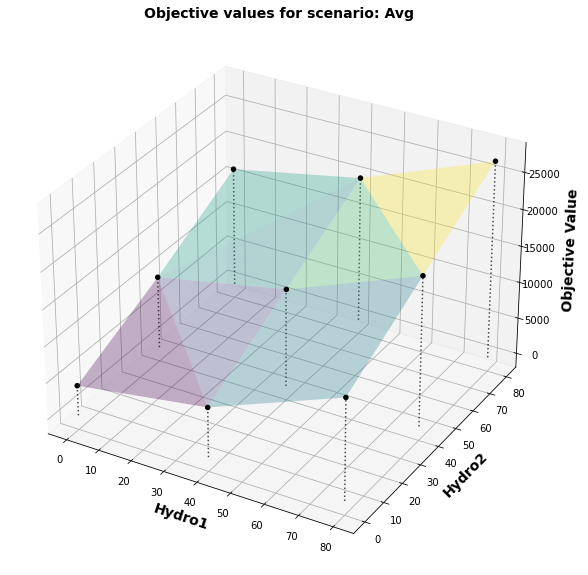

In [6]:
# Extract the first state and second state from each state combination tuple
state_combinations_x = [state[0] for state in List_combinations]
state_combinations_y = [state[1] for state in List_combinations]


# Plot state combinations and objective values for each scenario
for scenario_name, scenario_values in zip(scenarios.keys(), all_scenario_objective_values):
    slope = np.gradient(scenario_values)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    trisurf = ax.plot_trisurf(state_combinations_x, state_combinations_y, scenario_values, cmap=cm.viridis, linewidth=0.2, antialiased=True, alpha=0.3, facecolors=cm.viridis(slope))

    scatter = ax.scatter(state_combinations_x, state_combinations_y, scenario_values, color='black', marker='o', label='Objective value', alpha=1)
    #contour = ax.contour(state_combinations_x, state_combinations_y, scenario_values, zdir='z', offset=0, cmap='viridis', linestyles='dashed', alpha=0.5)
    
    # Draw dotted lines from scatter points
    for i in range(len(state_combinations_x)):
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [0, scenario_values[i]], linestyle='dotted', color='black', alpha=0.7)
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [scenario_values[i], scenario_values[i]], linestyle='dotted', color='C6', alpha=0.7)

    ax.set_xlabel("Hydro1",fontsize=14, fontweight='bold')
    ax.set_ylabel("Hydro2",fontsize=14, fontweight='bold')
    ax.set_zlabel("Objective Value",labelpad=10,fontsize=14, fontweight='bold')
    ax.set_title(f"Objective values for scenario: {scenario_name}",fontsize=14, fontweight='bold')

    plt.show()

## Task 4d - SDP for all stochastic scenarios ("High","Avg","Low") for 10 discrete states

In [7]:
scenarios =  {'High':1/3,'Avg':1/3,'Low':1/3}
solar_val_scenario = {'High':30,'Avg':15,'Low':0}

tot_obj = 0

all_scenario_objective_values = []

for s in scenarios:
    print('---------------------------------------------------------------------')
    print("Solving for scenario:",s,"with probability:",np.round(scenarios[s],2))
    print('---------------------------------------------------------------------')
    Solar_p = solar_val_scenario[s]          #input of solar data to be used in the optimization
    print("The amount of solar power for scenario",s,"is:",Solar_p,"MW")

    Min = 0
    Max = Constants["Hydro_cap"]

    states_jump = 8
    List_states = [i for i in range(Min,Max+states_jump,states_jump)]
    print("Number of discrete states:",len(List_states))

    Hydro1_initial_value = List_states
    Hydro2_initial_value = List_states
        
    List_combinations = [p for p in itertools.product(Hydro1_initial_value,Hydro2_initial_value)]
  
    #Pre-step: Formulate cut input data
    Cuts = {}
    Cuts["Set"] = []
    Cuts["Phi"] = {}
    Cuts["lambda"] = {}
    Cuts["x_hat"] = {}
    
    scenario_objective_values = []

    for initial_value in List_combinations:
        
        #Set 1st stage result
        X_hat = {
            "Hydro1": initial_value[0],
            "Hydro2": initial_value[1],
            }

        #Solve the 2nd stage problem for each state combination   
        initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat) 
        m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2, Scenario=scenarios[s])     
        Solve(m_2nd)

        #Aquire cuts
        Cuts = Cut_manage(Cuts,m_2nd)
        scenario_objective_values.append(pyo.value(m_2nd.obj))

    all_scenario_objective_values.append(scenario_objective_values)

    #Solve the 1st stage problem with the acquired cuts
    m_1st = ModelSetUp_1st(data, Constants,Cuts, Scenario=scenarios[s])
    Solve(m_1st)  
    X_hat = {
            "Hydro1": m_1st.p["Hydro1"],
            "Hydro2": m_1st.p["Hydro2"],
        }

    #Print results 1st stage
    for x in X_hat:
        print("Sold hydropower in the first stage from",x,"is:",X_hat[x].value,"MW")
    print("The objective value for scenario",s,"is:",pyo.value(m_1st.obj()))
    tot_obj += pyo.value(m_1st.obj()) #.alpha.value

print('')
print(">>>>-------------------------------------<<<<")
print("The objective value is:",np.round(tot_obj,2))
print(">>>>-------------------------------------<<<<")

---------------------------------------------------------------------
Solving for scenario: High with probability: 0.33
---------------------------------------------------------------------
The amount of solar power for scenario High is: 30 MW
Number of discrete states: 11
Sold hydropower in the first stage from Hydro1 is: 39.99999999999996 MW
Sold hydropower in the first stage from Hydro2 is: 0.0 MW
The objective value for scenario High is: 800.0000000049677
---------------------------------------------------------------------
Solving for scenario: Avg with probability: 0.33
---------------------------------------------------------------------
The amount of solar power for scenario Avg is: 15 MW
Number of discrete states: 11
Sold hydropower in the first stage from Hydro1 is: 24.999999999999957 MW
Sold hydropower in the first stage from Hydro2 is: 0.0 MW
The objective value for scenario Avg is: 1100.0000000049677
---------------------------------------------------------------------
Sol

### Plotting of Task 4d:

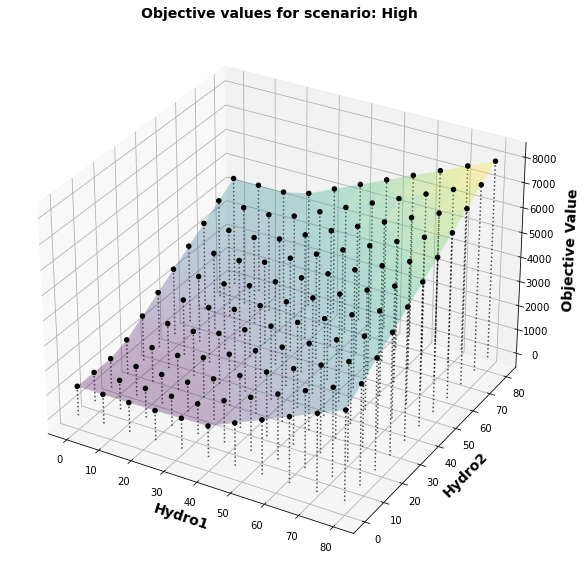

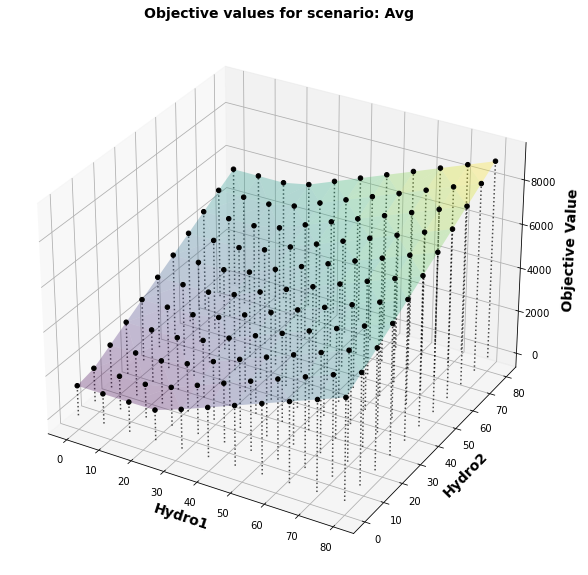

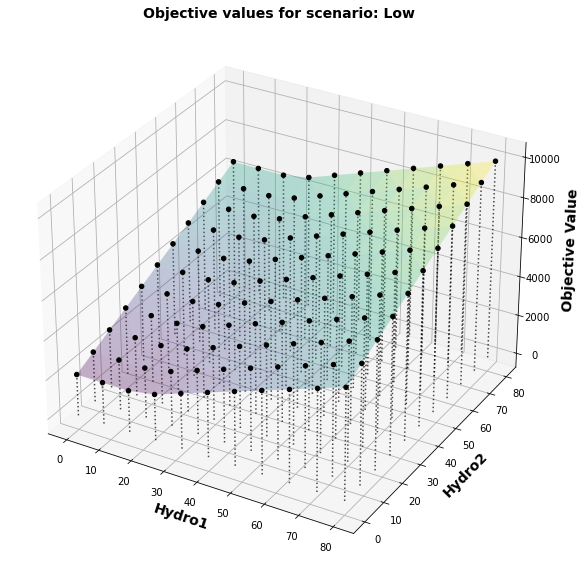

In [8]:
state_combinations_x = [state[0] for state in List_combinations]
state_combinations_y = [state[1] for state in List_combinations]


# Plot state combinations and objective values for each scenario
for scenario_name, scenario_values in zip(scenarios.keys(), all_scenario_objective_values):
    slope = np.gradient(scenario_values)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    trisurf = ax.plot_trisurf(state_combinations_x, state_combinations_y, scenario_values, cmap=cm.viridis, linewidth=0.2, antialiased=True, alpha=0.3, facecolors=cm.viridis(slope))

    scatter = ax.scatter(state_combinations_x, state_combinations_y, scenario_values, color='black', marker='o', label='Objective value', alpha=1)
    #contour = ax.contour(state_combinations_x, state_combinations_y, scenario_values, zdir='z', offset=0, cmap='viridis', linestyles='dashed', alpha=0.5)
    
    # Draw dotted lines from scatter points
    for i in range(len(state_combinations_x)):
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [0, scenario_values[i]], linestyle='dotted', color='black', alpha=0.7)
        ax.plot([state_combinations_x[i], state_combinations_x[i]], [state_combinations_y[i], state_combinations_y[i]], [scenario_values[i], scenario_values[i]], linestyle='dotted', color='C6', alpha=0.7)

    ax.set_xlabel("Hydro1",fontsize=14, fontweight='bold')
    ax.set_ylabel("Hydro2",fontsize=14, fontweight='bold')
    ax.set_zlabel("Objective Value",labelpad=10,fontsize=14, fontweight='bold')
    ax.set_title(f"Objective values for scenario: {scenario_name}",fontsize=14, fontweight='bold')

    plt.show()